# $\theta$ experiments

## Introduction

Flint's law (erm, actually Morisawa did it before in the 60s, Hack kind of went nearly to it in the late 50s, as well as Leopold and Maddock in the early 50s so let's call it "Flint"'s law) describes a river reach with the following equation:

\begin{equation}
S = k_s * Q^{-\theta}
\end{equation}

In order to extract comparable $k_{s}$, $\theta$ needs to be fixed to a reference value. This reference value is usually arbitrarily chosen to be 0.45, based on **very** few studies in the late 90s ~ early 2000s stating that NEAR STEADY STATE rivers might mainly show values around 0.45 in some context but that wide ranges of values have been reported. Later works on the subject demonstrated that (i) $\theta$ varies widely in space and (ii) it is very hard to see systematic forcings controlling $\theta$.

Some points emerge from these statement: First, if $\theta$ varies through space, it must vary through time as well otherwise it would mean $\theta$ would be some kind of predetermine skeleton. Then, if $\theta$ varies through time and space, is it reasonnable to keep constant the expressions of $\theta$ when studying landscape evolution? This is a pretty open question, which I will explore through this jupyter notebook.

## Proof of concept: external forcings affecting $\theta$ on simulated cases 

Let's first consider a river in steady state, I extract the river network of a real river to obtain a realistic distribution of drainage area 

### Extracting the river with lsdtopytools

In [1]:
import lsdtopytools as lsd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import helplotlib as hpl
import SPL as spl

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

mydem = lsd.LSDDEM(path = "../", file_name = "putna_50_NDF.tif", already_preprocessed = False)
mydem.PreProcessing()
mydem.CommonFlowRoutines()
mydem.ExtractRiverNetwork( method = "area_threshold", area_threshold_min = 1500)
mydem.DefineCatchment( method="main_basin")
mydem.GenerateChi(theta = 0.35, A_0 = 1)
df = mydem.df_base_river
#isolating main river
df = df[df["source_key"] == 0]
df.sort_values("elevation", inplace=True)

Loading the raster from file: ../putna_50_NDF.tif
LOADING TOOK 0.03502321243286133
I am recasting your nodata values to -9999 (standard LSDTT)
PREPROC TOOK 0.0016541481018066406
Alright, let me summon control upon the c++ code ...
Got it.
INGESTINGINTO CPP TOOK 0.0058269500732421875
FINALISATION TOOK 0.0001499652862548828
lsdtopytools is now ready to roll!
Carving: implementation of Lindsay (2016) DOI: 10.1002/hyp.10648
Filling: implementation of Wang and Liu (2006): https://doi.org/10.1080/13658810500433453
Processing...
DEM ready for flow routines!
Processing common flow routines...
Done!


/Users/gailleto/miniconda3/envs/ldstopytools/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Calculating a SS long profile

I can reconstruct a steady-state profile from bottom to top for a given $k_{sn}$ as follow:

\begin{equation}
z_i = z_r + (Q_i^{- \theta} * k_{sn}) * \Delta x
\end{equation}

with $z_r$ being the downstream receiver of $z_i$ and $z_0 = 0$.  

In [2]:
X = df.flow_distance.values - df.flow_distance.min()
Q = df.drainage_area.values
uplift = 0.001
erod = 2e-5
n=1
ksn = np.power(uplift/erod, 1/n)
theta = 0.45
Z = np.cumsum(np.power(Q,- theta)* ksn * np.concatenate([[0],np.diff(X)]))
S = np.concatenate([[0.],np.diff(Z)/np.diff(X)])


Text(0, 0.5, 'Elevation (m)')

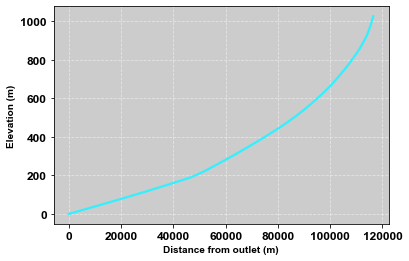

In [3]:
fig,ax = hpl.mkfig_grey_bold(figsize = (6,4))
ax.plot(X,Z, lw =2.23, color = "#33f0ff")
ax.set_xlabel("Distance from outlet (m)")
ax.set_ylabel("Elevation (m)")

/Users/gailleto/miniconda3/envs/ldstopytools/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'log[S]')

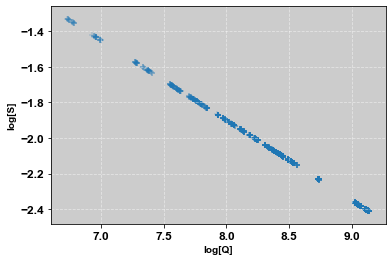

In [4]:
fig,ax = hpl.mkfig_grey_bold(figsize = (6,4))
ax.scatter(np.log10(Q),np.log10(S), marker = "+", alpha = 0.2)
ax.set_xlabel("log[Q]")
ax.set_ylabel("log[S]")

### Capture Event beheading this river

I am now beheading this river, removing 1/4 of its drainage area. 

In [5]:
id_of_capt = int(round(3*S.shape[0]/4))
Q_capt = Q[:id_of_capt] - Q[id_of_capt]
S_capt = S[:id_of_capt]
Z_capt = Z[:id_of_capt]
X_capt = X[:id_of_capt]

# Removing the very small Q to initiate the river at a decent size
mask = Q_capt > 1e7
Q_capt = Q_capt[mask]
S_capt = S_capt[mask]
Z_capt = Z_capt[mask]
X_capt = X_capt[mask]


/Users/gailleto/miniconda3/envs/ldstopytools/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/gailleto/miniconda3/envs/ldstopytools/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


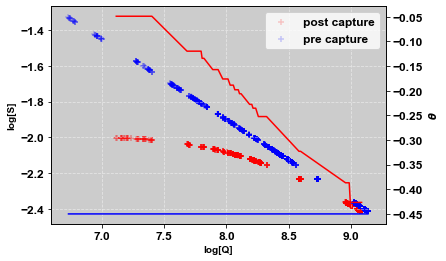

In [6]:
fig,ax = hpl.mkfig_grey_bold(figsize = (6,4))
ax.scatter(np.log10(Q_capt),np.log10(S_capt), marker = "+", alpha = 0.2, color = 'r', label = "post capture")
ax.scatter(np.log10(Q),np.log10(S), marker = "+", alpha = 0.2, color = 'b', label = "pre capture")

ax2 = ax.twinx()
n=7
# temp = np.diff(np.log10(S_capt))/ np.diff(np.log10(Q_capt))
# temp = np.diff(np.log10(S_capt))/ np.diff(np.log10(Q_capt))

# temp[0] = 0
# theta_capt = moving_average(temp, n)
# print(temp)
# print(Q_capt.shape)

# ax2.scatter(np.log10(Q_capt[n:]), theta_capt)
# ax2.plot(np.log10(Q_capt)[::n][1:], np.diff(np.log10(S_capt[::n]))/ np.diff(np.log10(Q_capt[::n])))
# ax2.plot(np.log10(Q)[::n][1:], np.diff(np.log10(S[::n]))/ np.diff(np.log10(Q[::n])))
# theta_pre = spl.calculate_theta_power_fit(Z,Q,X, 200)
# theta_post = spl.calculate_theta_power_fit(Z_capt,Q_capt,X_capt, 200)
# # print(theta_pre)

hb = 20
breaks = []
ksn_pre, theta_pre = spl.optimise_by_breaks(Q,S,breaks,  p0 = ([0,-np.inf],[np.inf,0]))
valcheck = np.diff(np.log10(Q_capt))
th = np.percentile(valcheck,2)
breaks = (np.argwhere(valcheck<th) +1).flatten()
breaks = breaks[(breaks>5) & (breaks<Q_capt.shape[0] - 5)]
cb = np.concatenate([[10], np.diff(breaks)])
breaks = breaks[cb>20]
ksn_post, theta_post = spl.optimise_by_breaks(Q_capt, S_capt,breaks, p0 = ([0,-np.inf],[np.inf,0]))

ax2.plot(np.log10(Q), theta_pre, color = 'b')
ax2.plot(np.log10(Q_capt), theta_post, color = 'r')


ax.set_xlabel("log[Q]")
ax.set_ylabel("log[S]")
ax2.set_ylabel(r"$\theta$")
ax.legend()

## Adapting the erodibility to the dynamic exponent

A problem I did not forsee is that erodibility is kind of function of theta as well. This is a very big problem, another one, which is hard to tackle. I am having an 

$\theta$ is affected at every points of the profile

### TODO

Add other scenarios changing concavity

## Dynamic exponent throught time

Here I used the theta cases exposed in the previous to feed a simple Stream Power Incision Law:

\begin{equation}
 E = K S^n A^m
\end{equation}

Where $\frac{m}{n} = \theta$ and $\frac{dz}{dt} = U(t,x) - E(t,x)$

In [32]:
tZ = np.copy(Z_capt)
tX = np.copy(X_capt)
n = 1
# uplift = 0.001
# erod = uplift/np.power(ksn,n)

U = np.zeros_like(tZ)+uplift
U[0] = 0
K = np.zeros_like(tZ)+erod

nZ = []
dt = 100
ndt = 1000
ndts = 1e4

for i in range(ndt):
    print(i, end = "||") if (i%int(1e2) == 0) else 0
    tS = np.concatenate([[0.],np.diff(tZ)/np.diff(tX)])
    valcheck = np.diff(np.log10(Q_capt))
    th = np.percentile(valcheck,2)
    breaks = (np.argwhere(valcheck<th) +1).flatten()
    breaks = breaks[(breaks>5) & (breaks<Q_capt.shape[0] - 5)]
    cb = np.concatenate([[10], np.diff(breaks)])
    breaks = breaks[cb>20]
    ksn_post, theta = spl.optimise_by_breaks(Q_capt, tS,breaks, p0 = ([0,-np.inf],[np.inf,0]))
    theta = -theta
    theta[theta>0.9] = 0.9
    theta[theta<0] = 0.05
#     theta = np.zeros_like(tZ)+ 0.45
    
    E = spl.Erosion_spl_explicit_fixed_n(tZ,tX,Q_capt,theta,K, n)
    E[0] = 0
    tZ = tZ - (E - U) * dt
    
    if(ndt % ndts == 0):
        nZ.append(np.copy(tZ))
    
    


0||100||200||300||400||500||600||

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

In [ ]:
fig,ax = hpl.mkfig_grey_bold(figsize = (6,4))
ax.scatter(X_capt, Z_capt, s = 1)
ax.scatter(tX, tZ, s = 1)
ax.set_xlim(0,1000)
ax.set_ylim(0,20)


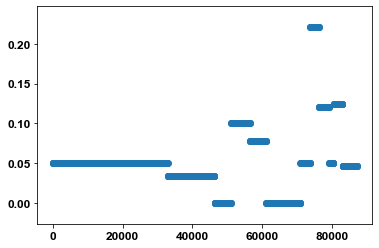

In [23]:
plt.scatter(tX,theta)

In [107]:
E

array([0.00000000e+00, 9.15312525e-05, 4.45321728e-06, ...,
       3.20501298e-05, 3.20194848e-05, 3.19662550e-05])

In [11]:
Q

array([1.3719953e+09, 1.3715237e+09, 1.3715186e+09, ..., 5.4422355e+06,
       5.4246800e+06, 5.3845535e+06], dtype=float32)

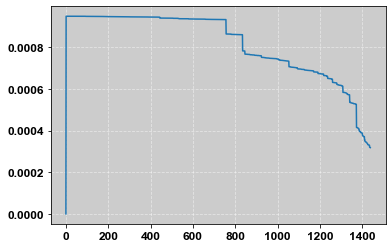

In [24]:
tZ = np.copy(Z_capt)
tX = np.copy(X_capt)
E_free = spl.Erosion_spl_explicit_fixed_n(tZ,tX,Q_capt,theta,K, n)
theta045 = np.zeros_like(tZ) + 0.45
E_norm = spl.Erosion_spl_explicit_fixed_n(tZ,tX,Q_capt,theta045,K, n)
fig,ax = hpl.mkfig_grey_bold(figsize = (6,4))
ax.plot(E_norm - E_free)